<a href="https://colab.research.google.com/github/asanneh/CS109B_Final_Project_Group_35/blob/master/CS109B_Final_Project_Group_35.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

    
##<div align="center">COMPSCI 109B Final Project - Group 35</div>







#<div align="center"> Project: Measuring the Shape and Brightness of Galaxies with Neural Networks</div>




#<div align='center'> Alpha Sanneh, Brian Tao, Grace Greason, Evan Arnold</div>



<div align='center>##Alpha Sanneh, Brian Tao, Grace Greason, Evan Arnold</div>

In [0]:
#install libraries we need here
# !pip install tf_keras_vis

In [0]:
#import relevant libraries
# from __future__ import annotations
import numpy as np
import seaborn as sns
import os
import datetime
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import pandas.util.testing as tm
sns.set()
%matplotlib inline

In [0]:

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.layers import Dense, Conv2D, Conv1D, MaxPooling2D, MaxPooling1D,\
#                                     Dropout, Flatten, Activation, Input, UpSampling2D
# from tensorflow.keras.optimizers import Adam, SGD, RMSprop
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.metrics import AUC, Precision, Recall, FalsePositives, \
#                                      FalseNegatives, TruePositives, TrueNegatives
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.regularizers import l2

In [0]:
# tf.keras.backend.clear_session()  # For easy reset of notebook state.
# print(tf.__version__)  

In [4]:
#Mount Google Drive
 from google.colab import drive
 drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
file_path = '/content/drive/My Drive/'
os.chdir(file_path)
print('Working Directory:',os.getcwd())

Working Directory: /content/drive/My Drive


In [0]:
# Read data
f=h5py.File('Data.h5','r')
image = f['img'][:]    
cat = f['cat'][:]  
label = f['label'][:]   # this gives the set of parameters that characterize the galaxy 
snr = f['snr'][:]
sigma = f['sigma'][:]
image_nonoise = f['img_nonoise'][:]    
image_withnoise = f['img_withnoise'][:]    
f.close()

In [7]:
# Get shape of images with noise and images without noise
image.shape, image_nonoise.shape

((18779, 64, 64), (18779, 64, 64))

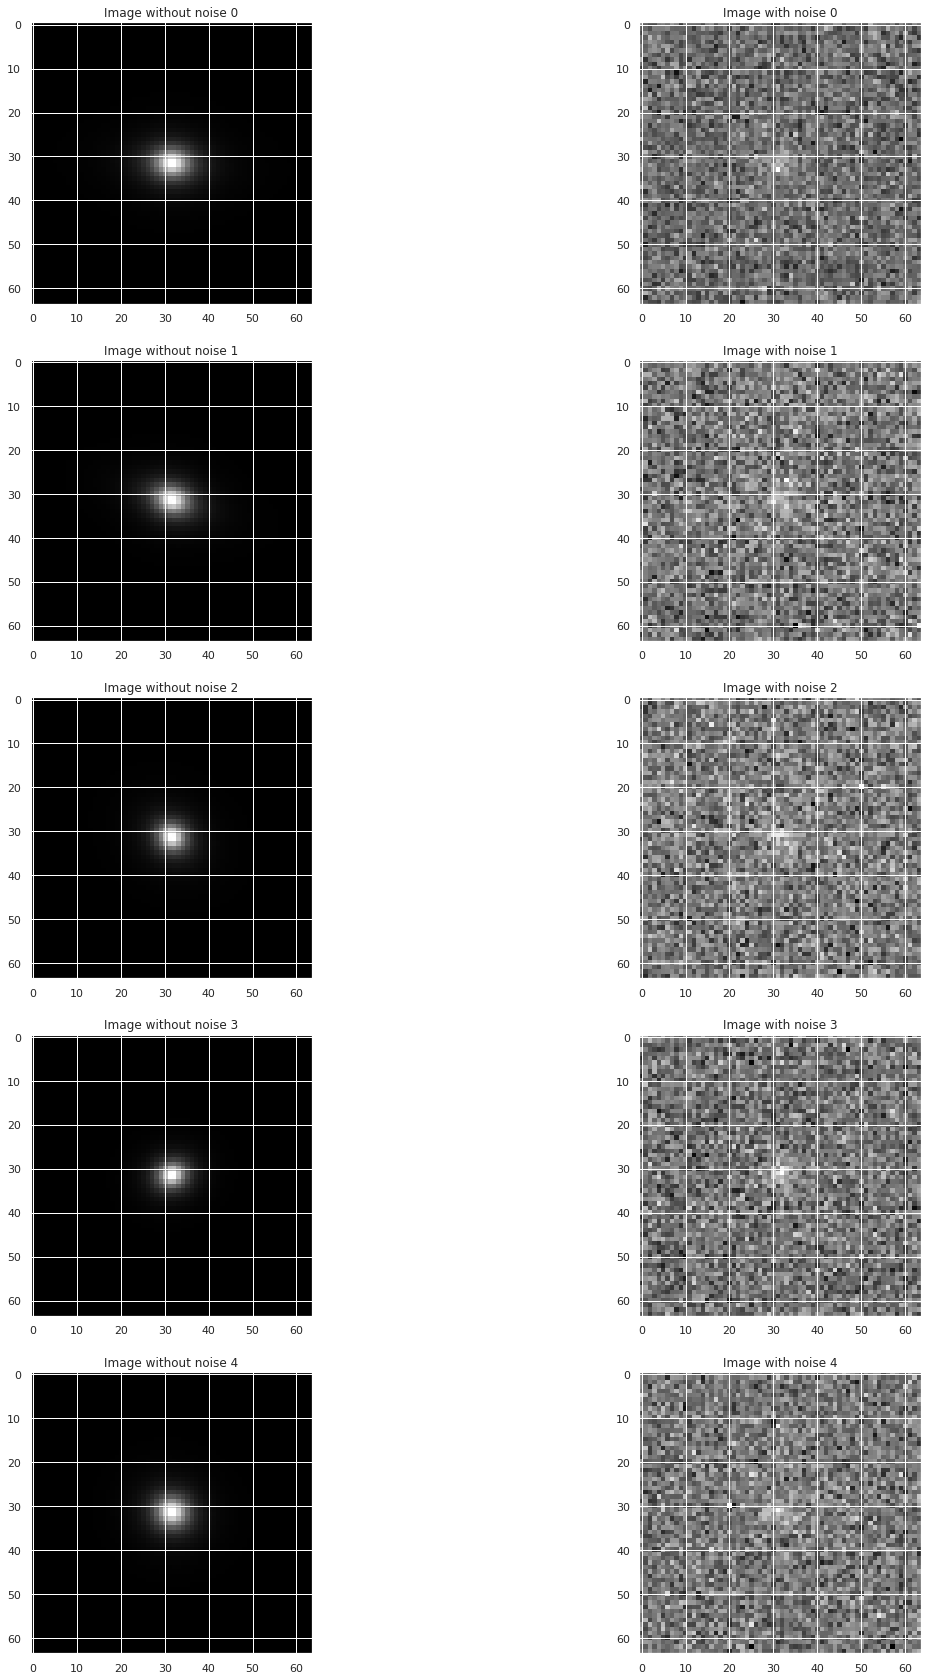

In [38]:
# Plot the first five images with and without noise
fig, ax = plt.subplots(5,2, figsize=(20,30))
for i in range(5):
    ax[i][0].imshow(image_nonoise[i], cmap='gray')
    ax[i][0].set_title('Image without noise {}'.format(i))
    ax[i][1].imshow(image_withnoise[i], cmap='gray')
    ax[i][1].set_title('Image with noise {}'.format(i))

**Distribution of Noise:** Below we plot the histogram of the noise of the dataset along with the best fit normal distribution. We do so to verify that the noise is indeed Gaussian. This will inform our model design. Specifically, it will allow us to model the noise in order to better predict the response.

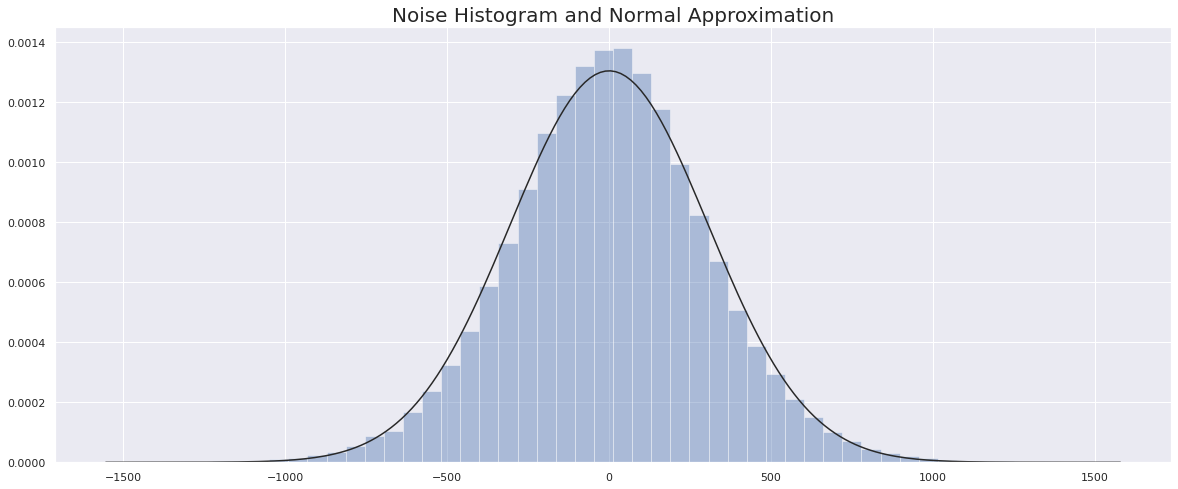

In [39]:
from scipy.stats import norm
# distribution of noise (first n pixels for efficiency)
n = 100000
# noise
noise = image_withnoise - image_nonoise
noise = noise.reshape(-1, 1)
# plot
fig, ax = plt.subplots(figsize=(20,8))
sns.distplot(noise[1:n], fit=norm, kde=False, ax=ax)
ax.set_title('Noise Histogram and Normal Approximation', fontsize=20);

**Response Distribution/Correlation:** As shown below, the response variables have no significant correlation aside from g1 and g2. We expect the scatters of circles as both g1 and g2 are functions of the same variables using different sinusoid functions (cos vs. sin). Care should be taken when modeling g1 and g2 as their outcome is highly correlated (though in a non-linear fashion).

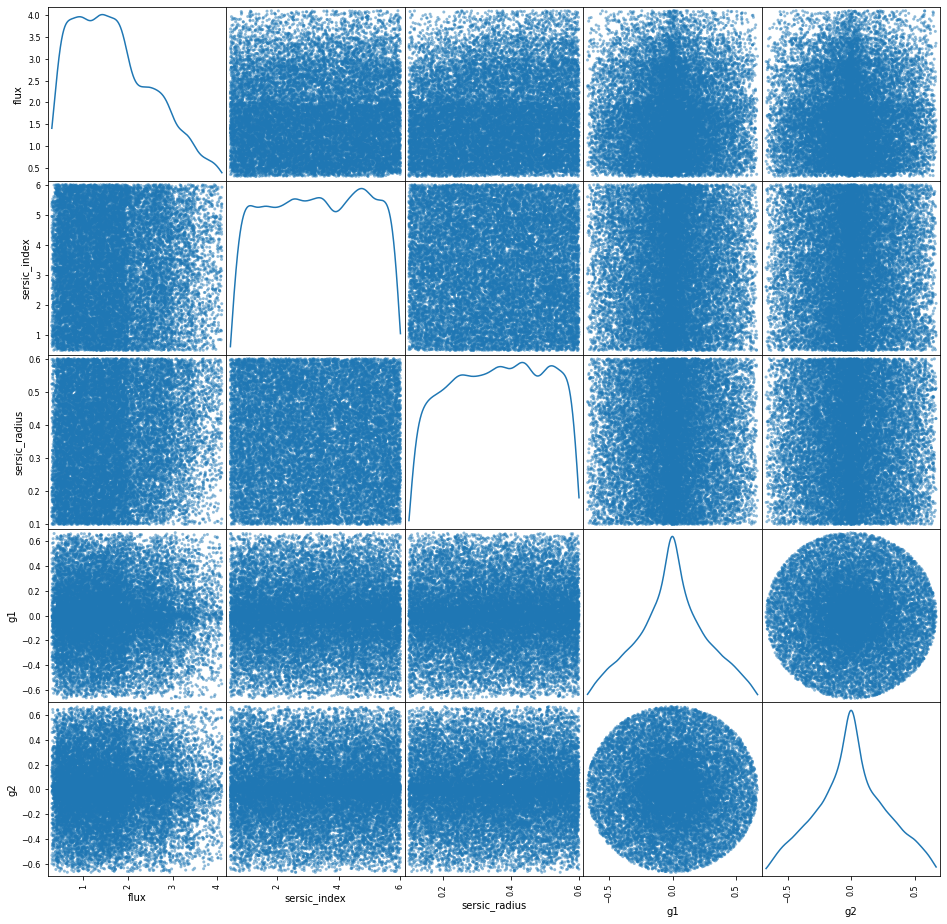

In [11]:

# convert response 2D array to labeled dataframe
label_df = pd.DataFrame(label, columns=['flux', 'sersic_index', 'sersic_radius', 'g1', 'g2'])
# scatter matrix of response
pd.plotting.scatter_matrix(label_df, figsize=(16, 16), diagonal='kde');

In [40]:
print(f'Image with noise max: {image_withnoise[0].max()}')
print(f'Image with noise min: {image_withnoise[0].min()}')
print(f'Image with no noise max: {image_nonoise[0].max()}')
print(f'Image with no noise min: {image_nonoise[0].min()}')

Image with noise max: 1088.6094996083598
Image with noise min: -799.6288667294024
Image with no noise max: 455.3077087402344
Image with no noise min: 0.03963421285152435


Below we plot the distributions of the parameters that characterize each galaxy.

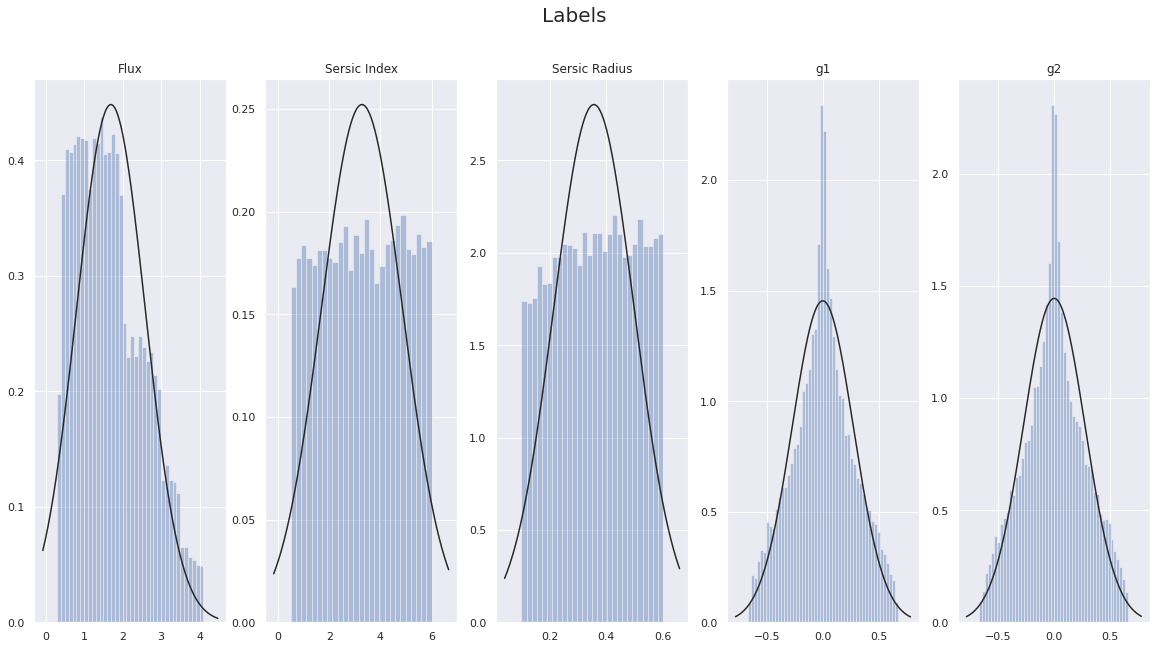

In [43]:
fig, ax = plt.subplots(1,5, figsize=(20,10));
fig.suptitle('Labels', fontsize=20)
sns.distplot(label[:, 0], fit=norm, kde=False,  ax=ax[0]).set_title('Flux')
sns.distplot(label[:, 1], fit=norm, kde=False,  ax=ax[1]).set_title('Sersic Index')
sns.distplot(label[:, 2], fit=norm, kde=False, ax=ax[2]).set_title('Sersic Radius')
sns.distplot(label[:, 3], fit=norm, kde=False, ax=ax[3]).set_title('g1')
sns.distplot(label[:, 4], fit=norm, kde=False, ax=ax[4]).set_title('g2')
plt.show()

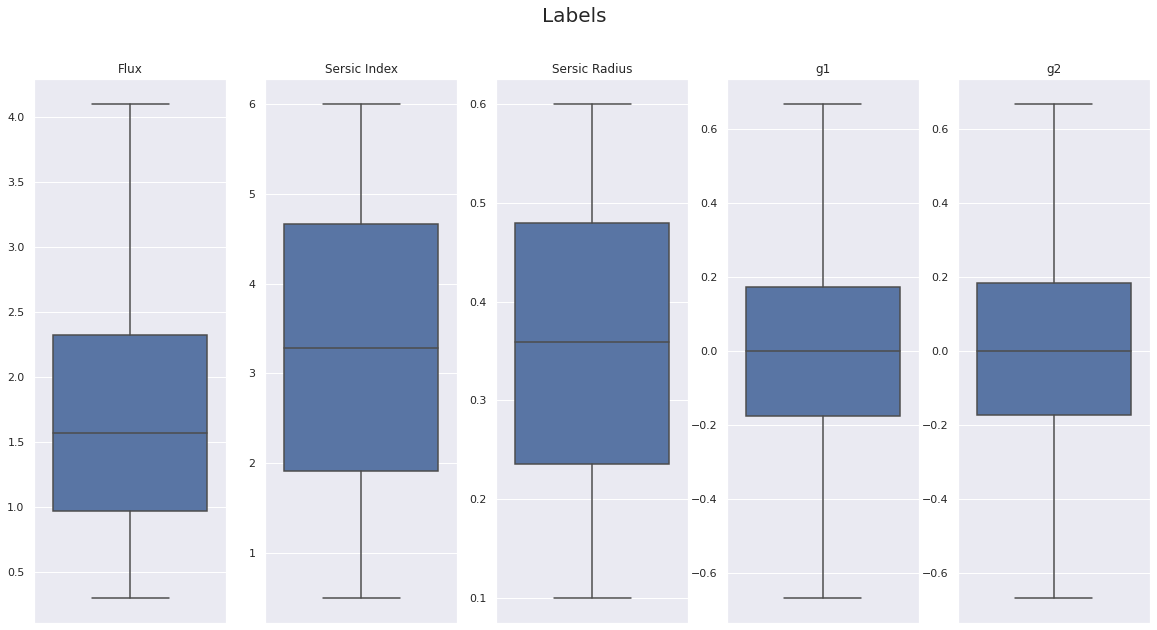

In [0]:
fig, ax = plt.subplots(1,5, figsize=(20,10));
fig.suptitle('Labels')

fig.suptitle('Labels', fontsize=20)
sns.boxplot(label[:, 0],  ax=ax[0], orient='v').set_title('Flux')
sns.boxplot(label[:, 1],  ax=ax[1], orient='v').set_title('Sersic Index')
sns.boxplot(label[:, 2],  ax=ax[2], orient='v').set_title('Sersic Radius')
sns.boxplot(label[:, 3],  ax=ax[3],orient='v').set_title('g1')
sns.boxplot(label[:, 4],  ax=ax[4], orient='v').set_title('g2')
plt.show()


Below is the distribution of the sound to noise ratio of the galaxies. The code to simulate a galaxy removes all galaxies with ratios less than 10 or greater than 100, which is evident from the distribution.

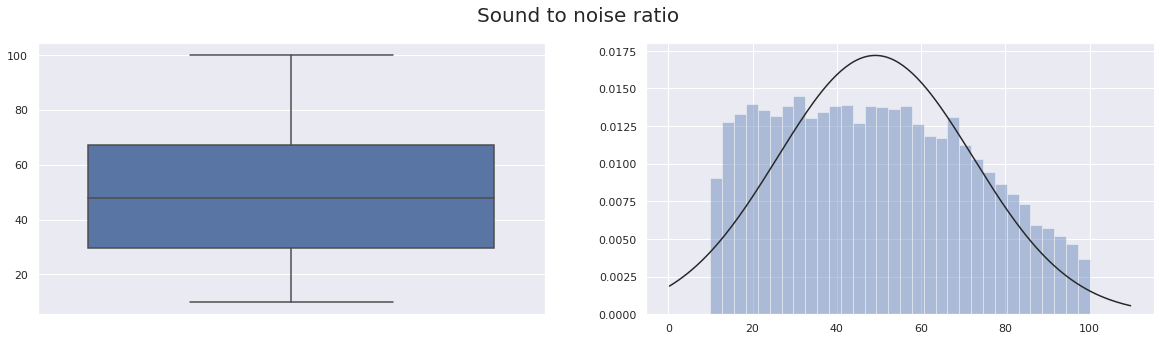

In [0]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
fig.suptitle('Sound to noise ratio', fontsize=20);

sns.boxplot(snr, ax=ax[0], orient='v');
sns.distplot(snr, fit=norm, kde=False, ax=ax[1])
plt.show()


Below is the distribution for sigma, which was used to construct the noise map for each galaxy. As expected, sigma has a uniform distribution.

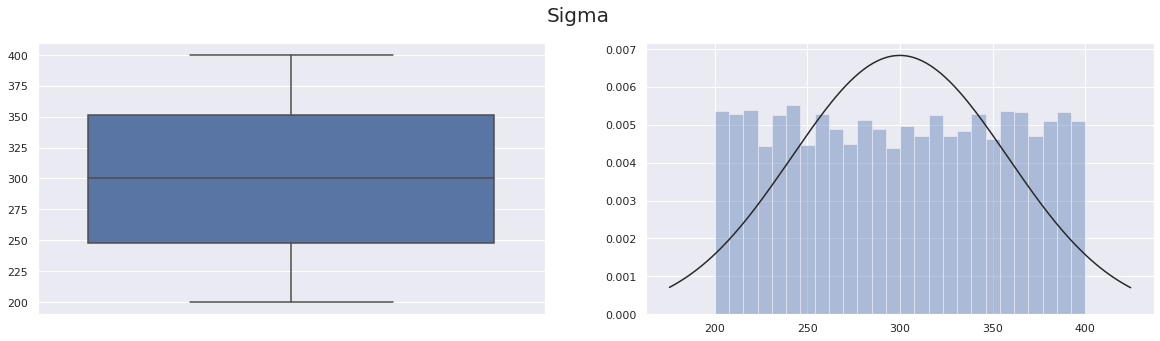

In [0]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
fig.suptitle('Sigma', fontsize=20);

sns.boxplot(sigma, ax=ax[0], orient='v');
sns.distplot(sigma, fit=norm, kde=False, ax=ax[1])
plt.show()